In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [41]:
class PopulationEvolution:
    def __init__(self, population_size = 100, top_k = 20, type = 2, nawards = 5, main_genotype_length = 1, max_meta_level = 1, meta_initialization = 0.1, meta_mutation_rate = 0.1, nr_of_generations = 2000, referential = False, elitism = False, discretize_bids = True, print_elites = True, use_meta_only_necessary = True, value = 1, level_randomizer_initialization = False, max_level_initialization = 0, prob_level_change = 0.2, mutation_type = 2, verbose = False):        
        """
        Initialize the parameters.

        Parameters:
        -----------
        population_size : int, default=100
            The size of the population, equal for both populations. Must be >=1.
        
        top_k : int, default=20
            The number of top individuals selected for reproduction. Must be >= 1 and <= population_size.

        main_genotype_length : int, default=1
            The length of the main part of the genotype (the part of the genome that does not contain meta-parameters), i.e., the part representing the solution.

        max_meta_level : int, default=1
            The maximum possible number of metaparameters for the individuals from the population. Must be >= 0.

        meta_initialization : float, default=0.1
            Std used during initialization of the metaparameters (normal distribution). (All metaparameters are initialized to the same value.) Must be > 0.

        meta_mutation_rate : float, default=0.1
            Must be > 0. If regular meta-mutation scheme is used, this is the (external) meta mutation rate. In that case, it is used only if self-referential mutations rates are inactive (referential = False).
            If additive meta-mutation scheme is used instead, this is effectively the noise parameter, as in "Arbitrary Order Meta-Learning with Simple Population-Based Evolution" by Lu et al., 2023.

        nr_of_generations : int, default=2000
            The number of generations for the algorithm to run.

        referential : bool, default=False
            Whether or not to use the self-referential top meta-mutation rate. Applies equally to both populations.

        elitism : bool, default=True
            If True, retains a certain number of top-performing individuals in each generation.

        value : float, default=0.5
            The value of the auctioned item, identical for all players. Should be positive.
        
        level_randomizer_initialization : bool, default=False
            Whether or not meta-levels are initialized randomly at the beginning
        
        max_level_initialization: float, default=1
            The maximum level to which agents are initialized. Should be >0 and <= max_meta_level. If level_randomizer_initialization = False, all agents' meta levels are initialized to this value.

        prob_level_change : float, default=0.2
            The probability of the meta-order change in the offsping.
        
        mutation_type: int, default=1
            The type of meta-mutation scheme used - regular (1) or additive (2).

        verbose: bool, default=False,
            Prints additional info (population members) every 100 generations.

        Raises:
        -------
        ValueError:
            If any of the input parameters do not meet the constraints mentioned above.
        """

        if population_size < 1:
            raise ValueError("Invalid population size, should be >=1")
        if (top_k < 1) or (top_k > population_size):
            raise ValueError("Invalid number of elites, should be >=1 and <= population size")
        if main_genotype_length < 1:
            raise ValueError("Invalid length of the main genotype, should be >=1")
        if max_meta_level < 0:
            raise ValueError("Invalid maximum number of metaparameters, should be >=0") 
        if meta_initialization <= 0:
            raise ValueError("Invalid value for the meta_initialization parameter, should be > 0 since it is used as a scale/std")
        if meta_mutation_rate <= 0:
            raise ValueError("Invalid meta_mutation_rate parameter, should be > 0 since it is used as a scale/std") 
        if value <= 0:
            raise ValueError("Invalid value for the value of the auctioneed item, should be > 0")
        if (max_level_initialization < 0) or (max_level_initialization > max_meta_level):
            raise ValueError("Invalid value for the max_level_initialization parameter, should be > 0 and <= max_meta_level")
        if (prob_level_change < 0) or (prob_level_change>1):
            raise ValueError("Invalid probability!")
        if mutation_type not in [1,2]:
            raise ValueError("Invalid value for the mutation_type parameter, should be equal to 1 (regular meta-mutation rates) or 2 (additive meta-mutation rates)")        
        if type not in [1,2]:
            raise ValueError("Invalid value for the type parameter, should be equal to 1 (single award auction) or 2 (multiple award auction)")        
        if ((nawards < 1) or (nawards > top_k)) and (type == 2):
            raise ValueError("Invalid number of players!")
        self.population_size = population_size
        self.top_k = top_k
        self.type = type
        self.nawards = nawards
        self.main_genotype_length = main_genotype_length
        self.max_meta_level = max_meta_level
        self.discretize_bids = discretize_bids
        self.print_elites = print_elites,
        self.use_meta_only_necessary = use_meta_only_necessary
        self.meta_initialization = meta_initialization
        self.meta_mutation_rate = meta_mutation_rate
        self.nr_of_generations = nr_of_generations
        self.referential = referential
        self.elitism = elitism
        self.value = value
        self.level_randomizer_initialization = level_randomizer_initialization
        self.max_level_initialization = max_level_initialization
        self.prob_level_change = prob_level_change
        self.mutation_type = mutation_type
        self.t = 0 # time/current generation
        self.verbose = verbose
        self.population = self.initialize_population(self.max_meta_level)

    def initialize_population(self, maxmetalevel):
        e1 = np.random.normal(0,self.meta_initialization,(self.main_genotype_length+maxmetalevel,self.population_size))
        if self.level_randomizer_initialization:
            e2 = np.random.randint(0,self.max_level_initialization+1,self.population_size)
        else:
            e2 = self.max_level_initialization*np.ones(self.population_size)
        #print(np.vstack((e1,e2)).T)
        return np.vstack((e1,e2)).T

    def play(self, solution):
        if self.discretize_bids:
            return round((abs(solution)/ 0.05)) * 0.05
        else:
            return abs(solution)
    
    def match(self, solutions, value):
        # List to store the actions of each solution
        actions = [self.play(solution) for solution in solutions]
        
        # Find the highest action (the winner)
        max_action = max(actions)
        
        # Find all indices of solutions that have the maximum action
        winners = [i for i, action in enumerate(actions) if action == max_action]
        
        # Determine the number of winners
        num_winners = len(winners)
        
        # Initialize the payoffs for each solution
        payoffs = [-action for action in actions]
        
        for i in winners:
            payoffs[i] += (value / num_winners) 
        
        # Return the payoffs along with the corresponding actions
        return np.array(payoffs), np.array(actions)
    
    def matchmulti(self, solutions, value):
        # List to store the actions of each solution
        actions = [self.play(solution) for solution in solutions]
        # Initialize the payoffs for each solution
        payoffs = [-action for action in actions]
        sorted_indices = sorted(range(len(actions)), key=lambda i: actions[i], reverse=True)
        for i in range(self.nawards):
            payoffs[sorted_indices[i]] += value*(1-i/self.nawards)
        # Return the payoffs along with the corresponding actions
        return np.array(payoffs), np.array(actions)

    def mutate(self, solution, mrate):
        new_solution = copy.deepcopy(solution)
        metalevel = int(solution[-1])
        if metalevel > 0:
            if self.referential == False:
                if metalevel == self.max_meta_level:
                    new_solution[self.main_genotype_length+metalevel-1] = solution[self.main_genotype_length+metalevel-1]+np.random.normal(0, mrate)
                elif self.use_meta_only_necessary:
                    new_solution[self.main_genotype_length+metalevel-1] = solution[self.main_genotype_length+metalevel-1]+np.random.normal(0, abs(solution[self.main_genotype_length+metalevel]))
                else:
                    new_solution[self.main_genotype_length+metalevel-1] = solution[self.main_genotype_length+metalevel-1]+np.random.normal(0, mrate)
            else:
                new_solution[self.main_genotype_length+metalevel-1] = solution[self.main_genotype_length+metalevel-1]+np.random.normal(0, abs(solution[self.main_genotype_length+metalevel-1]))
            for i in range(metalevel+self.main_genotype_length-2,-1,-1):
                if i >= self.main_genotype_length:
                    new_solution[i] = solution[i]+np.random.normal(0, abs(solution[i+1]))
                else:
                    new_solution[i] = solution[i]+np.random.normal(0, abs(solution[self.main_genotype_length]))
        else:
            if self.referential == False:
                new_solution[:-1] = solution[:-1] + np.random.normal(0, mrate, len(solution[:-1]))
            else:
                new_solution[:-1] = solution[:-1] + np.random.normal(0, abs(solution[:-1]))
        die = np.random.uniform()
        if (die <= self.prob_level_change/2) and (metalevel>0):
            new_solution[-1] -= 1
        elif (die <= self.prob_level_change) and (metalevel<self.max_meta_level):
            new_solution[-1] += 1
        else:
            pass
        return new_solution
    
    def mutate_additive(self, solution, mrate): # UNFINISHED!!!!!!!!!!!!!!!!
        print("Warning!!! Stop!!")
        new_solution = copy.deepcopy(solution)
        metalevel = int(solution[-1])
        if metalevel > 0:
            if self.referential == False:
                new_solution[self.main_genotype_length+metalevel-1] = solution[self.main_genotype_length+metalevel-1]+np.random.normal(0, mrate)
            else:
                new_solution[self.main_genotype_length+metalevel-1] = solution[self.main_genotype_length+metalevel-1]+np.random.normal(solution[self.main_genotype_length+metalevel-1], mrate)
            for i in range(metalevel+self.main_genotype_length-2,-1,-1):
                if i >= self.main_genotype_length:
                    new_solution[i] = solution[i]+np.random.normal(solution[i+1], mrate)
                else:
                    new_solution[i] = solution[i]+np.random.normal(solution[self.main_genotype_length], mrate)
        else:
            if self.referential == False:
                new_solution[:-1] = solution[:-1] + np.random.normal(0, mrate, len(solution[:-1]))
            else:
                new_solution[:-1] = solution[:-1] + np.random.normal(solution[:-1], mrate) #check
        die = np.random.uniform()
        if (die <= self.prob_level_change/2) and (metalevel>0):
            new_solution[-1] -= 1
        elif (die <= self.prob_level_change) and (metalevel<self.max_meta_level):
            new_solution[-1] += 1
        else:
            pass
        return new_solution

    def evolve(self):
        mean_scores, std_scores  = [], [] # mean scores, std scores
        mean_as, std_as = [], [] # mean actions, std actions
        mean_metas, std_metas = [], [] #meta meta-parameters, std meta-parameters
        mean_scores_elite, std_scores_elite  = [], [] # mean scores, std scores (elites)
        mean_as_elite, std_as_elite = [], [] # mean actions (elites), std actions (elites)
        mean_metas_elite, std_metas_elite = [], [] #meta meta-parameters (elites), std meta-parameters (elites)
        for t in range(0, self.nr_of_generations):
            self.t = t
            if self.type == 2:
                scores, acs = self.matchmulti(self.population[:,0], self.value)
            else:
                scores, acs = self.match(self.population[:,0], self.value)
            mean_scores.append(np.mean(scores))
            std_scores.append(np.std(scores))
            mean_as.append(np.mean(acs))
            std_as.append(np.std(acs))
            top_indices = np.argsort(scores)[-self.top_k:]
            if self.print_elites:
                print("Elite actions: ", acs[top_indices])
            #print("All actions: ", acs)
            #top_indices = np.random.choice(range(len(scores)), self.top_k, replace=False) #randomizer
            #print(self.population[top_indices,-1])
            mean_scores_elite.append(np.mean(scores[top_indices]))
            std_scores_elite.append(np.std(scores[top_indices]))
            mean_as_elite.append(np.mean(acs[top_indices]))
            std_as_elite.append(np.std(acs[top_indices]))
            if len(self.population[0]) > 1: #inactive genes are also caught here
                mean_metas.append(np.mean(self.population[:,1:],axis=0))
                std_metas.append(np.std(self.population[:,1:],axis=0))
                mean_metas_elite.append(np.mean(self.population[top_indices,1:],axis=0))
                std_metas_elite.append(np.std(self.population[top_indices,1:],axis=0))
            if self.t % 100 == 0:
                print('Generation: {}'.format(t))
                if self.verbose:
                    print("Top population members: ", self.population[top_indices])
            # Building the new populations
            new_population = []
            if self.elitism == True:
                for i in top_indices:
                    new_population.append(self.population[i])
            while len(new_population) < self.population_size:
                parent = copy.deepcopy(self.population[np.random.choice(top_indices)])
                if self.mutation_type == 1:
                    new_population.append(self.mutate(parent, self.meta_mutation_rate))
                else:
                    new_population.append(self.mutate_additive(parent, self.meta_mutation_rate))
            self.population = np.array(new_population)
        return np.array(mean_scores), np.array(std_scores), np.array(mean_as), np.array(std_as), np.array(mean_metas), np.array(std_metas), np.array(mean_scores_elite), np.array(std_scores_elite), np.array(mean_as_elite), np.array(std_as_elite), np.array(mean_metas_elite), np.array(std_metas_elite)

In [42]:
popevo = PopulationEvolution(
    population_size = 50, 
    top_k = 5, 
    type = 1, # KEEP FIXED!!!!! (1 for single-prize, 2 for multi-prize)
    nawards = 25, # KEEP FIXED!!!!! (nr of awards if multi)
    main_genotype_length = 1, # KEEP FIXED!!!!!
    max_meta_level = 5, 
    meta_initialization = 0.01, 
    meta_mutation_rate = 0.01,
    nr_of_generations = 10000,
    referential = False, # KEEP FIXED!!!!!
    elitism = False, 
    discretize_bids = True, # KEEP FIXED!!!!!
    print_elites = True, # KEEP FIXED!!!!!
    use_meta_only_necessary = True,
    value = 1, # KEEP FIXED!!!!!
    level_randomizer_initialization = False, # KEEP FIXED!!!!!
    max_level_initialization = 0, # KEEP FIXED!!!!!
    prob_level_change = 0.2, # KEEP FIXED!!!!!
    mutation_type = 1, # KEEP FIXED!!!!!
    verbose = False) # KEEP FIXED!!!!!
mean_scores, std_scores, mean_as, std_as, mean_metas, std_metas, mean_scores_elite, std_scores_elite, mean_as_elite, std_as_elite, mean_metas_elite, std_metas_elite  = popevo.evolve()

Elite actions:  [0.   0.   0.   0.05 0.05]
Generation: 0
Elite actions:  [0.05 0.05 0.05 0.05 0.05]
Elite actions:  [0.  0.  0.  0.  0.1]
Elite actions:  [0.   0.   0.   0.15 0.15]
Elite actions:  [0.  0.  0.  0.2 0.2]
Elite actions:  [0.   0.   0.   0.25 0.25]
Elite actions:  [0. 0. 0. 0. 0.]
Elite actions:  [0.  0.  0.  0.  0.1]
Elite actions:  [0.   0.   0.   0.15 0.15]
Elite actions:  [0.   0.   0.   0.   0.25]
Elite actions:  [0.  0.  0.3 0.3 0.3]
Elite actions:  [0. 0. 0. 0. 0.]
Elite actions:  [0.  0.  0.  0.1 0.1]
Elite actions:  [0. 0. 0. 0. 0.]
Elite actions:  [0.05 0.05 0.05 0.05 0.05]
Elite actions:  [0.   0.   0.15 0.15 0.15]
Elite actions:  [0.  0.  0.  0.  0.5]
Elite actions:  [0. 0. 0. 0. 0.]
Elite actions:  [0.   0.   0.   0.   0.45]
Elite actions:  [0. 0. 0. 0. 0.]
Elite actions:  [0.  0.  0.  0.  0.2]
Elite actions:  [0. 0. 0. 0. 0.]
Elite actions:  [0.  0.  0.  0.  0.4]
Elite actions:  [0.  0.  0.  0.  0.6]
Elite actions:  [0. 0. 0. 0. 0.]
Elite actions:  [0.05 0.05

Mean score, 1st population:  -0.08730274
Mean dispersion, 1st population:  0.20707860498596575
Mean elite score, 1st population:  0.0041834


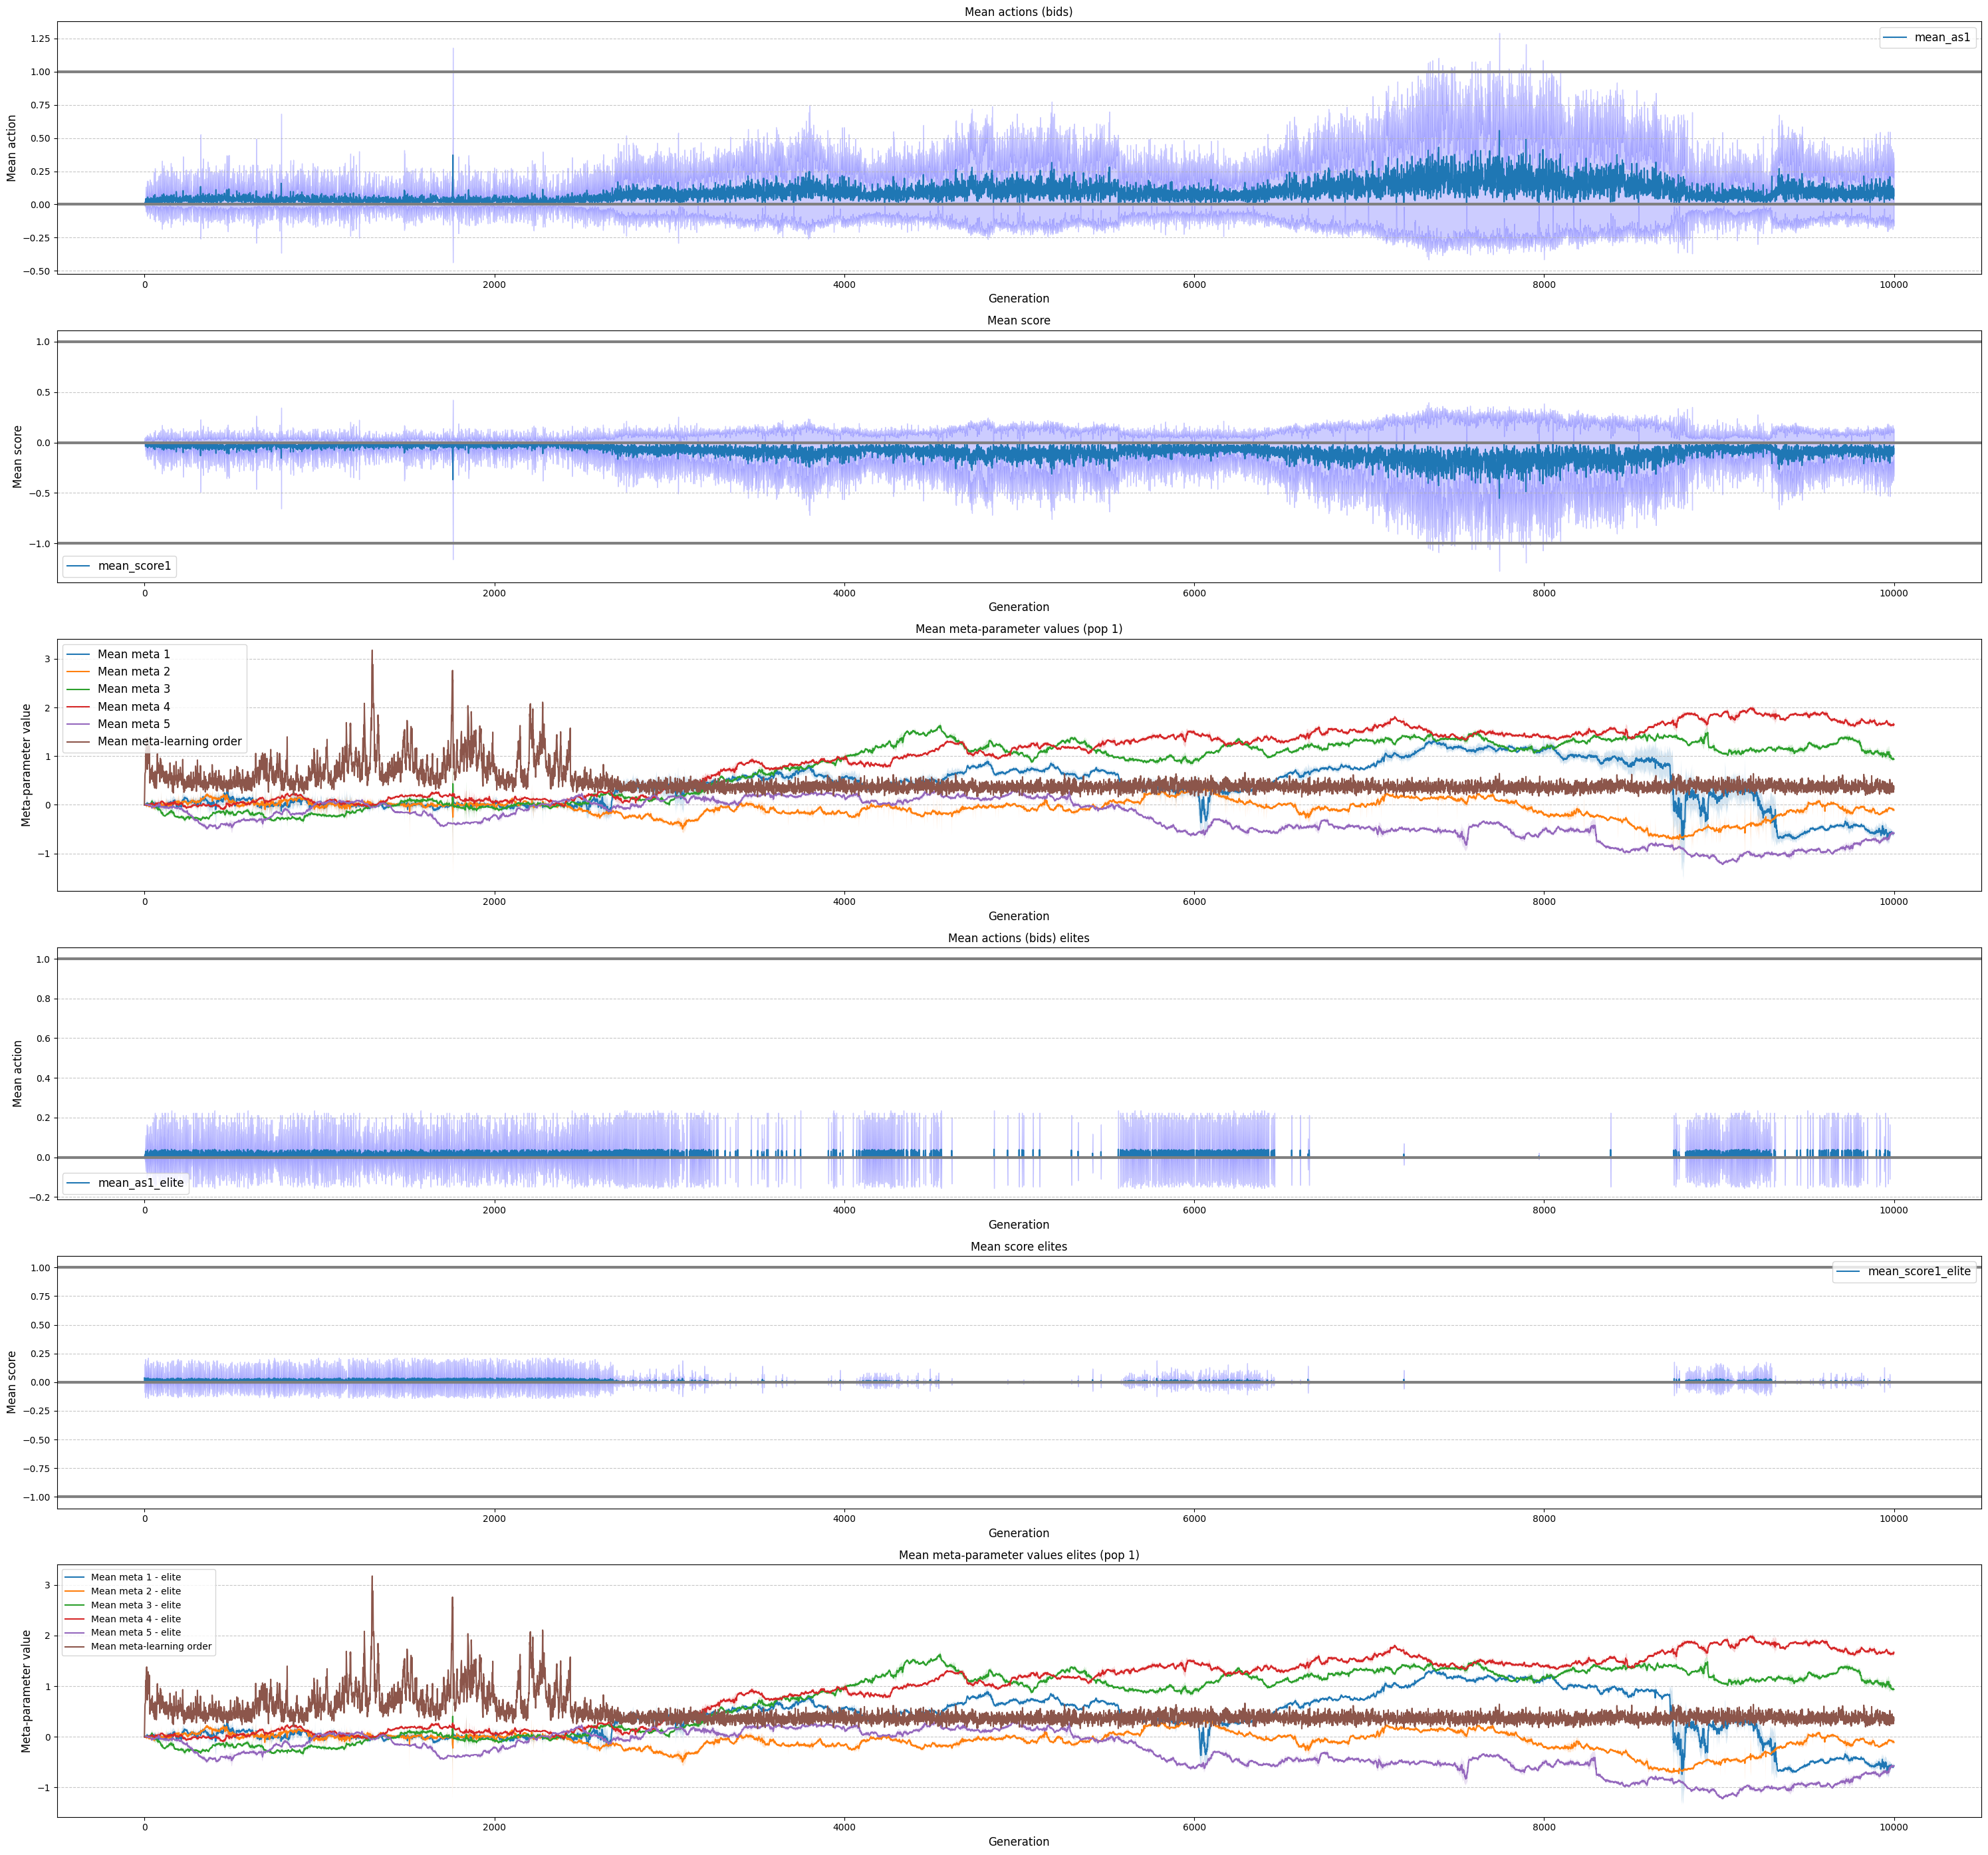

In [37]:
def plotter(start_t,final_t):
    plotcounter = 1
    plt.figure(figsize=(30, 28))
    
    # First subplot: Mean actions (bids)
    plt.subplot(6, 1, plotcounter)
    plt.plot(mean_as[start_t:final_t])
    plt.fill_between(np.arange(final_t-start_t), mean_as[start_t:final_t] - std_as[start_t:final_t], 
                     mean_as[start_t:final_t] + std_as[start_t:final_t], color='blue', alpha=0.2)
    plt.axhline(y=0, color='gray', linestyle='-', linewidth=3)
    plt.axhline(y=1, color='gray', linestyle='-', linewidth=3)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.title("Mean actions (bids)", fontsize=12)
    plt.xlabel("Generation", fontsize=12)
    plt.ylabel("Mean action", fontsize=12)
    plt.legend(["mean_as1"], fontsize=12)
    
    # Second subplot: Mean score
    plotcounter += 1
    plt.subplot(6, 1, plotcounter)
    plt.plot(mean_scores[start_t:final_t])
    plt.fill_between(np.arange(final_t-start_t), mean_scores[start_t:final_t] - std_scores[start_t:final_t], 
                     mean_scores[start_t:final_t] + std_scores[start_t:final_t], color='blue', alpha=0.2)
    plt.axhline(y=-1, color='gray', linestyle='-', linewidth=3)
    plt.axhline(y=0, color='gray', linestyle='-', linewidth=3)
    plt.axhline(y=1, color='gray', linestyle='-', linewidth=3)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.title("Mean score", fontsize=12)
    plt.xlabel("Generation", fontsize=12)
    plt.ylabel("Mean score", fontsize=12)
    plt.legend(["mean_score1"], fontsize=12)

    # Third subplot: Mean meta-parameter values (pop 1)
    #if mean_metas.ndim > 1:
    plotcounter += 1
    plt.subplot(6, 1, plotcounter)
    for i in range(mean_metas.shape[1]-1):
        plt.plot(mean_metas[start_t:final_t][:, i], label="Mean meta {}".format(i+1))
        plt.fill_between(np.arange(final_t-start_t), mean_metas[start_t:final_t][:, i] - std_metas[start_t:final_t][:, i], 
                        mean_metas[start_t:final_t][:, i] + std_metas[start_t:final_t][:, i], alpha=0.2)
    plt.plot(mean_metas[start_t:final_t][:, -1], label="Mean meta-learning order")
    #plt.axhline(y=-1, color='gray', linestyle='-', linewidth=3)
    #plt.axhline(y=-0.5, color='gray', linestyle='--', linewidth=3)
    #plt.axhline(y=0, color='gray', linestyle='-', linewidth=3)
    #plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=3)
    #plt.axhline(y=1, color='gray', linestyle='-', linewidth=3)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.title("Mean meta-parameter values (pop 1)", fontsize=12)
    plt.xlabel("Generation", fontsize=12)
    plt.ylabel("Meta-parameter value", fontsize=12)
    plt.legend(fontsize=12)

    # Fifth subplot: Mean actions (bids) elites
    plotcounter += 1  
    plt.subplot(6, 1, plotcounter)
    plt.plot(mean_as_elite[start_t:final_t])
    plt.fill_between(np.arange(final_t-start_t), mean_as_elite[start_t:final_t] - std_as_elite[start_t:final_t], 
                     mean_as_elite[start_t:final_t] + std_as_elite[start_t:final_t], color='blue', alpha=0.2)
    plt.axhline(y=0, color='gray', linestyle='-', linewidth=3)
    plt.axhline(y=1, color='gray', linestyle='-', linewidth=3)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.title("Mean actions (bids) elites", fontsize=12)
    plt.xlabel("Generation", fontsize=12)
    plt.ylabel("Mean action", fontsize=12)
    plt.legend(["mean_as1_elite"], fontsize=12)

    # Sixth subplot: Mean score elites
    plotcounter += 1  
    plt.subplot(6, 1, plotcounter)
    plt.plot(mean_scores_elite[start_t:final_t])
    plt.fill_between(np.arange(final_t-start_t), mean_scores_elite[start_t:final_t] - std_scores_elite[start_t:final_t], 
                     mean_scores_elite[start_t:final_t] + std_scores_elite[start_t:final_t], color='blue', alpha=0.2)
    plt.axhline(y=-1, color='gray', linestyle='-', linewidth=3)
    plt.axhline(y=0, color='gray', linestyle='-', linewidth=3)
    plt.axhline(y=1, color='gray', linestyle='-', linewidth=3)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.title("Mean score elites", fontsize=12)
    plt.xlabel("Generation", fontsize=12)
    plt.ylabel("Mean score", fontsize=12)
    plt.legend(["mean_score1_elite"], fontsize=12)

    # Seventh subplot: Meta elites 1st pop
    #if mean_metas_elite.ndim > 1:    
    plotcounter += 1  
    plt.subplot(6, 1, plotcounter)
    for i in range(mean_metas_elite.shape[1]-1):
        plt.plot(mean_metas_elite[start_t:final_t][:,i],label="Mean meta {} - elite".format(i+1))
        plt.fill_between(np.arange(final_t-start_t), mean_metas_elite[start_t:final_t][:,i] - std_metas_elite[start_t:final_t][:,i], 
                        mean_metas_elite[start_t:final_t][:,i] + std_metas_elite[start_t:final_t][:,i], alpha=0.2)
    plt.plot(mean_metas[start_t:final_t][:, -1], label="Mean meta-learning order")
    #plt.axhline(y=-1, color='gray', linestyle='-', linewidth=3)
    #plt.axhline(y=-0.5, color='gray', linestyle='--', linewidth=3)
    #plt.axhline(y=0, color='gray', linestyle='-', linewidth=3)
    #plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=3)
    #plt.axhline(y=1, color='gray', linestyle='-', linewidth=3)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.title("Mean meta-parameter values elites (pop 1)", fontsize=12)
    plt.xlabel("Generation", fontsize=12)
    plt.ylabel("Meta-parameter value", fontsize=12)
    plt.legend()    
    print("Mean score, 1st population: ", np.mean(mean_scores))
    print("Mean dispersion, 1st population: ", np.mean(std_scores))
    print("Mean elite score, 1st population: ", np.mean(mean_scores_elite))
    #print("Mean elite score, 2nd population: ", np.mean(mean_scores2_elite))
    plt.tight_layout()  
plotter(0,popevo.nr_of_generations)
#plotter(0,1000)

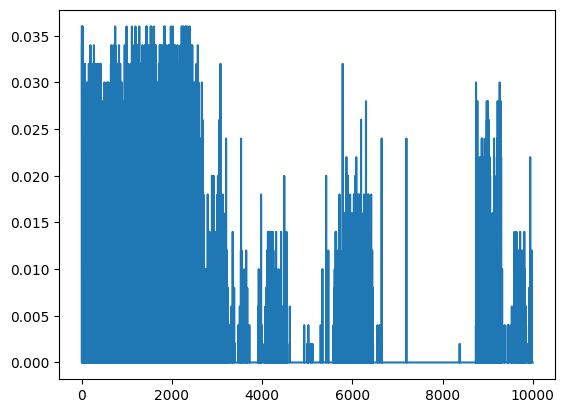

In [38]:
plt.plot(mean_scores_elite)

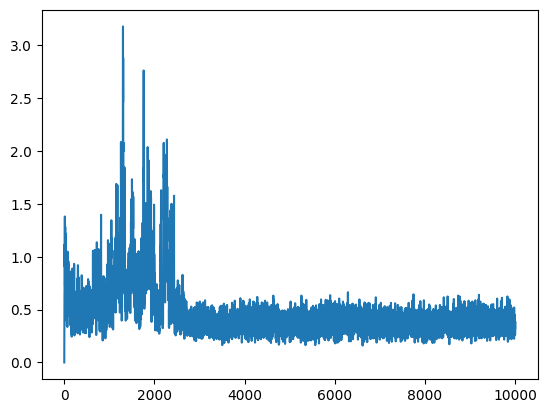

In [39]:
plt.plot(mean_metas[0:popevo.nr_of_generations][:, -1])

In [17]:
np.mean(mean_metas[0:popevo.nr_of_generations][:, -1])

0.45252